<a href="https://colab.research.google.com/github/SuwandiRamadhan/Project-3-NLP/blob/main/CNN_LSTM_project3_voice-recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Nama : M. Iqbal Baskoro

                      PROJECT 3 : VOICE RECOGNITION
              Klasifikasi Maksud Ucapan (Intent Classification)


### Data dan Algoritma Understanding

#### TUJUAN :
Membangun model yang dapat mengenali dan
mengklasifikasikan maksud (intent) dari sebuah rekaman suara.

#### DATASET:
https://huggingface.co/datasets/PolyAI/minds14

#### <Strong>Data Field</Strong>

| Nama Kolom | Tipe Data | Keterangan |
|:----------:|:---------:|:----------:|
|`path `| String | Path to the audio file |
|`audio `| Dict | Audio object including loaded audio array, sampling rate and path ot audio |
|`transcription `| String | Transcription of the audio file |
|`english_transcription `| String | English transcription of the audio file |
|`intent_class `| Integer | Class id of intent |
|`lang_id `| Integer | Id of language |

#### <strong>Penggunaan Bahasa Pada Dataset</strong>
-`en-US`

#### <strong>Pengolahan Dataset</strong>
-`Pembagian Dataset` = <strong>Training</strong>(80%) dan <strong>Test</strong>(20%) <br>
-`Audio Preprocessing` = <strong>Resampling</strong>, Audio diseragamkan ke sampling rate 16000 Hz <br>


#### MODEL :
Training model menggunakan `LSTM` <br>
Feature Extraction `MFCC`

### Model Training & Evaluation

In [ ]:
import os
import random
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from IPython.display import Audio, display
from tqdm import tqdm

# untuk data dan model
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import  Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Conv1D, MaxPooling1D, BatchNormalization, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l2

# Fungsi untuk hasil yang reproducible
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(42)

C:\Users\SUWAAAN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# Load dataset
print('Sedang memuat dataset PolyAI/minds14...')
dataset = load_dataset('PolyAI/minds14', 'all', split='train')

df = pd.DataFrame(dataset)
print(f'Dataset berhasil dimuat dengan : \n{len(df)} baris dan {len(df.columns)} kolom.')

df['path'] = df['path'].apply(os.path.abspath)
print(f'\nDataset berhasil dimuat ke dalam DataFrame')

intent_names = dataset.features['intent_class'].names
print(f'Jumlah kelas intent : {len(intent_names)}')

Sedang memuat dataset PolyAI/minds14...
Dataset berhasil dimuat dengan : 
8168 baris dan 6 kolom.

Dataset berhasil dimuat ke dalam DataFrame
Jumlah kelas intent : 14


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8168 entries, 0 to 8167
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   path                   8168 non-null   object
 1   audio                  8168 non-null   object
 2   transcription          8168 non-null   object
 3   english_transcription  8168 non-null   object
 4   intent_class           8168 non-null   int64 
 5   lang_id                8168 non-null   int64 
dtypes: int64(2), object(4)
memory usage: 383.0+ KB


In [ ]:
df.head()

,path,audio,transcription,english_transcription,intent_class,lang_id
0,C:\Users\SUWAAAN\.cache\huggingface\datasets\d...,{'path': 'C:\Users\SUWAAAN\.cache\huggingface\...,Dobrý den potřeboval bych zjistit jaký je maxi...,"Hello, I need to find out what is the maximum ...",3,0
1,C:\Users\SUWAAAN\.cache\huggingface\datasets\d...,{'path': 'C:\Users\SUWAAAN\.cache\huggingface\...,Dobrý den Budu si poprvé vybírat peníze z vaše...,Hello I will withdraw money from your ATM for ...,3,0
2,C:\Users\SUWAAAN\.cache\huggingface\datasets\d...,{'path': 'C:\Users\SUWAAAN\.cache\huggingface\...,Jaký je limit který si můžu vybrat z bankomatu,What is the limit I can choose from an ATM,3,0
3,C:\Users\SUWAAAN\.cache\huggingface\datasets\d...,{'path': 'C:\Users\SUWAAAN\.cache\huggingface\...,Kolik peněz si můžu vybrat z bankomatu,How much money can I withdraw from an ATM,3,0
4,C:\Users\SUWAAAN\.cache\huggingface\datasets\d...,{'path': 'C:\Users\SUWAAAN\.cache\huggingface\...,Dobrý den rád bych se vás zeptal Chtěl bych si...,"Hello, I would like to ask you I would like to...",3,0


C:\Users\SUWAAAN\AppData\Local\Temp\ipykernel_19184\1990622209.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y='intent_name', order=df['intent_name'].value_counts().index, palette='viridis')


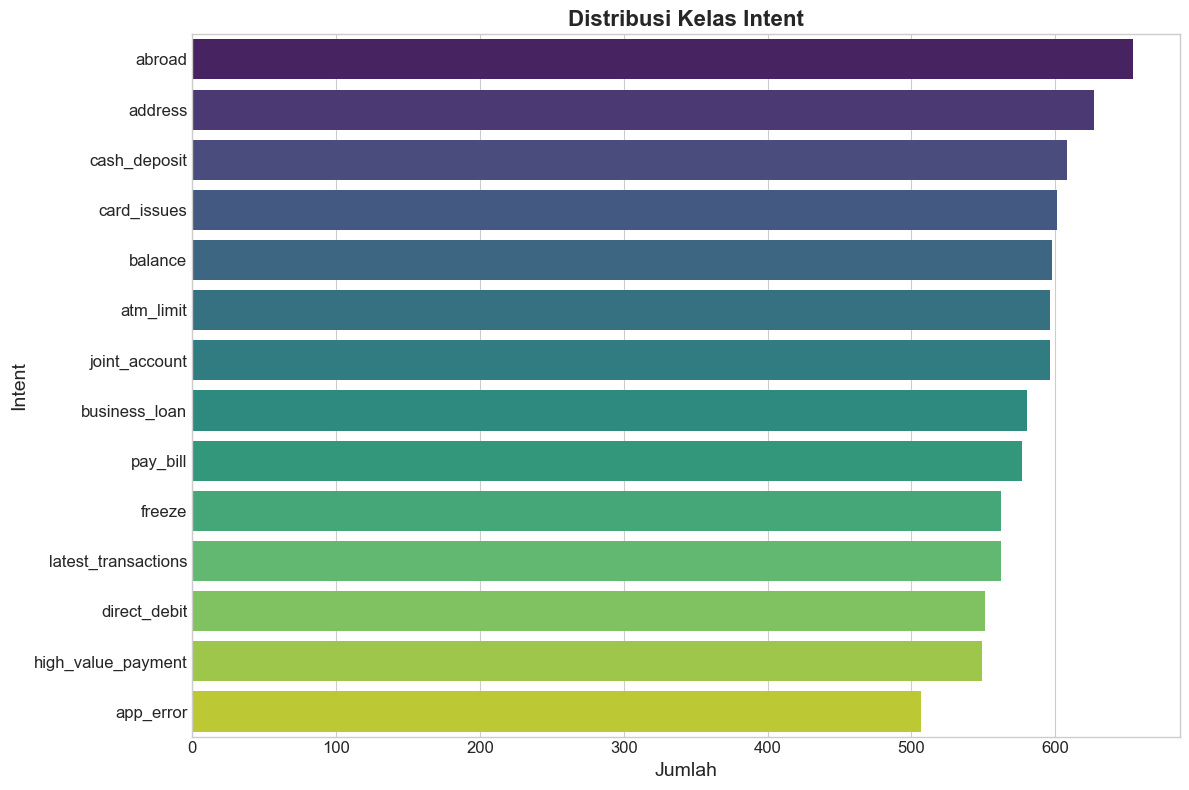

In [ ]:
df['intent_name'] = df['intent_class'].apply(lambda x: intent_names[x])

plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(12, 8))

sns.countplot(data=df, y='intent_name', order=df['intent_name'].value_counts().index, palette='viridis')
plt.title('Distribusi Kelas Intent', fontdict={'fontsize': 16, 'fontweight': 'bold'})
plt.xlabel('Jumlah', fontdict={'fontsize': 14})
plt.ylabel('Intent', fontdict={'fontsize': 14})
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

plt.show()

Intent : direct_debit
Transcript : 자동이체를 하고 싶은데 자동이체 하는 방법 좀 알려 주세요


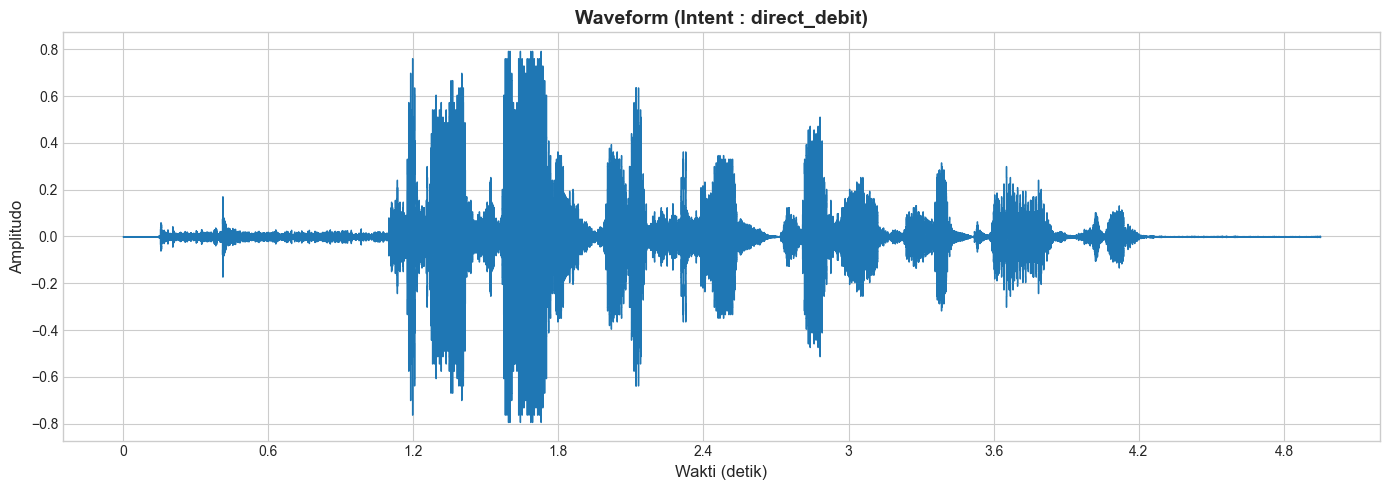

Audio berdasarkan transkript :


In [ ]:
random_index = random.randint(0, len(df) - 1)
sample = df.iloc[random_index]

audio_path = sample['path']
intent_label = sample['intent_name']
transcription = sample['transcription']

print(f'Intent : {intent_label}')
print(f'Transcript : {transcription}')

audio_array, sr = librosa.load(audio_path, sr=None, res_type='kaiser_fast')
# Buat Plot
plt.figure(figsize=(14, 5))
ax = plt.subplot(1, 1, 1)
librosa.display.waveshow(audio_array, sr=sr, ax=ax)
plt.title(f'Waveform (Intent : {intent_label})', fontdict={'fontsize': 14, 'fontweight': 'bold'})
plt.xlabel('Wakti (detik)', fontsize=12)
plt.ylabel('Amplitudo', fontsize=12)

plt.tight_layout()
plt.show()

print(f'Audio berdasarkan transkript :')
display(Audio(data=audio_array, rate=sr))

In [ ]:
!pip install resampy

In [ ]:
def extract_features(file_path):
    audio, sample_rate = librosa.load(file_path, res_type='kaiser_fast')

    # Ekstrak MFCCs
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=13)

    # Ekstrak delta MFCCs (kecepatan perubahan)
    delta_mfccs = librosa.feature.delta(mfccs)

    # Ekstrak delta2 MFCCs (akselerasi)
    delta2_mfccs = librosa.feature.delta(mfccs, order=2)

    # Gabung
    features = np.concatenate((mfccs, delta_mfccs, delta2_mfccs))

    return features

print(f'Mengekstrak fitur dari setiap file audio ...')
features = [extract_features(path) for path in tqdm(df['path'])]

max_pad_len = max([feature.shape[1] for feature in features if feature is not None])
print(f'Panjang padding maks : {max_pad_len}')

def pad_features(features, pad_len):
    if features.shape[1] < pad_len:
        pad_width = pad_len - features.shape[1]
        features = np.pad(features, pad_width=((0, 0), (0, pad_width)), mode='constant')
    else:
        features = features[:, :pad_len]
    return features

print(f'Melakukan padding pada semua fitur...')
padded_features = [pad_features(f, max_pad_len) for f in tqdm(features) if f is not None]

# Konversi ke array NumPy
X = np.array(padded_features)
X = X.transpose(0, 2, 1)          # (n_sample, timesteps, n_features)

print(f'\nEkstraksi Selesai : \nShape data fitur (X) : {X.shape}')

Mengekstrak fitur dari setiap file audio ...


100%|██████████| 8168/8168 [05:27<00:00, 24.97it/s]


Panjang padding maks : 2925
Melakukan padding pada semua fitur...


100%|██████████| 8168/8168 [00:02<00:00, 3526.93it/s]



Ekstraksi Selesai : 
Shape data fitur (X) : (8168, 2925, 39)


In [ ]:
# Encod label dan Pembagian dataset

y = df['intent_class'].values

# Buat dan latih LabelEncoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Konversi ke one hot encoding
y_categorical = to_categorical(y_encoded)
num_classes = len(label_encoder.classes_)
print(f'Label diubah ke format one-hot encoding \nShape data label (y) : {y_categorical.shape}')

# Bagi dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y_categorical, test_size=0.2, random_state=42, stratify=y_categorical
)

print(f'Jumlah data train : {X_train.shape}')
print(f'Jumlah data test : {X_test.shape}')

Label diubah ke format one-hot encoding 
Shape data label (y) : (8168, 14)
Jumlah data train : (6534, 2925, 39)
Jumlah data test : (1634, 2925, 39)


In [ ]:
# Normalisasi Fitur
scaler = StandardScaler()

# Reshape data agar bisa scale ke 2D
n_sample_train, n_timesteps_train, n_features_train = X_train.shape
X_train_reshaped = X_train.reshape(-1, n_features_train)

scaler.fit(X_train_reshaped)

# Transform data training
X_train_scaled_reshaped = scaler.transform(X_train_reshaped)
X_train = X_train_scaled_reshaped.reshape(n_sample_train, n_timesteps_train, n_features_train)

# Transform data testing dengan scaler
n_sample_test, n_timesteps_test, n_features_test = X_test.shape
X_test_reshaped = X_test.reshape(-1, n_features_test)
X_test_scaled_reshaped = scaler.transform(X_test_reshaped)
X_test = X_test_scaled_reshaped.reshape(n_sample_test, n_timesteps_test, n_features_test)

print(f'Fitur Training dan Testing selesai di normalisasi')

# Simpan scaler
model_dir = '../model'
with open(os.path.join(model_dir, 'scaler.pkl'), 'wb') as f:
    pickle.dump(scaler, f)
print(f'Scaler berhasil disimpan ke {model_dir}')

Fitur Training dan Testing selesai di normalisasi
Scaler berhasil disimpan ke ../model


In [ ]:
# Arsitektur model LSTM
input_shape = (X_train.shape[1], X_train.shape[2])

model = Sequential ([
    Input(shape=input_shape),

    # Layer Konvolusi untuk ekstraksi fitur
    Conv1D(64, kernel_size=5, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),

    Conv1D(128, kernel_size=5, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),

    # Lapisan LSTM Bidirectional
    Bidirectional(LSTM(128, return_sequences=True)),
    Dropout(0.2),

    Bidirectional(LSTM(64, return_sequences=False)),
    Dropout(0.2),

    # Lapisan Dense
    Dense(64, activation='relu'),
    Dropout(0.2),

    Dense(num_classes, activation='softmax')
])

lr=0.001
# Compile model
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=lr),
              metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 2925, 64)       │        12,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 2925, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 1462, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1462, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 1462, 128)      │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 1462, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 731, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 731, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 731, 256)       │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 731, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 14)             │           910 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 491,086 (1.87 MB)

 Trainable params: 490,702 (1.87 MB)

 Non-trainable params: 384 (1.50 KB)

In [ ]:
best_model_path = os.path.join(model_dir, 'voice_intent_model.h5')

# Parameter training
epochs = 25
batch_size = 32
callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=15, verbose=1, mode='max', restore_best_weights=True),
    ModelCheckpoint(
        filepath=best_model_path,
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1,
        mode='max'
    )
]

print(f'Memulai training...')
history = model.fit(
    X_train,
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_test, y_test),
    callbacks=callbacks,
    verbose=1
)
print(f'Training Selesai...')

# Simpan LabelEncoder
with open(os.path.join(model_dir, 'label_encoder.pkl'), 'wb') as f:
    pickle.dump(label_encoder, f)

print(f'\nModel sudah disimpan di : {best_model_path}')

Memulai training...
Epoch 1/25
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 581ms/step - accuracy: 0.0639 - loss: 2.6587
Epoch 1: val_accuracy improved from -inf to 0.08201, saving model to ../model\voice_intent_model.h5


205/205 ━━━━━━━━━━━━━━━━━━━━ 138s 639ms/step - accuracy: 0.0639 - loss: 2.6587 - val_accuracy: 0.0820 - val_loss: 2.6383
Epoch 2/25
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 582ms/step - accuracy: 0.0790 - loss: 2.6391
Epoch 2: val_accuracy improved from 0.08201 to 0.08935, saving model to ../model\voice_intent_model.h5


205/205 ━━━━━━━━━━━━━━━━━━━━ 141s 635ms/step - accuracy: 0.0790 - loss: 2.6391 - val_accuracy: 0.0894 - val_loss: 2.6379
Epoch 3/25
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 595ms/step - accuracy: 0.0822 - loss: 2.6377
Epoch 3: val_accuracy did not improve from 0.08935
205/205 ━━━━━━━━━━━━━━━━━━━━ 133s 648ms/step - accuracy: 0.0822 - loss: 2.6377 - val_accuracy: 0.0863 - val_loss: 2.6367
Epoch 4/25
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 584ms/step - accuracy: 0.0799 - loss: 2.6379
Epoch 4: val_accuracy did not improve from 0.08935
205/205 ━━━━━━━━━━━━━━━━━━━━ 131s 637ms/step - accuracy: 0.0799 - loss: 2.6379 - val_accuracy: 0.0869 - val_loss: 2.6378
Epoch 5/25
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 581ms/step - accuracy: 0.0779 - loss: 2.6368
Epoch 5: val_accuracy did not improve from 0.08935
205/205 ━━━━━━━━━━━━━━━━━━━━ 130s 634ms/step - accuracy: 0.0779 - loss: 2.6369 - val_accuracy: 0.0851 - val_loss: 2.6376
Epoch 6/25
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 586ms/step - accuracy: 0.0859 - loss: 2.6372
Epoch 6: va

205/205 ━━━━━━━━━━━━━━━━━━━━ 127s 622ms/step - accuracy: 0.0818 - loss: 2.6360 - val_accuracy: 0.0949 - val_loss: 2.6378
Epoch 9/25
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 558ms/step - accuracy: 0.0839 - loss: 2.6352
Epoch 9: val_accuracy did not improve from 0.09486
205/205 ━━━━━━━━━━━━━━━━━━━━ 125s 610ms/step - accuracy: 0.0839 - loss: 2.6352 - val_accuracy: 0.0936 - val_loss: 2.6474
Epoch 10/25
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 560ms/step - accuracy: 0.0858 - loss: 2.6365
Epoch 10: val_accuracy did not improve from 0.09486
205/205 ━━━━━━━━━━━━━━━━━━━━ 125s 610ms/step - accuracy: 0.0858 - loss: 2.6365 - val_accuracy: 0.0857 - val_loss: 2.6379
Epoch 11/25
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 520ms/step - accuracy: 0.0860 - loss: 2.6353
Epoch 11: val_accuracy did not improve from 0.09486
205/205 ━━━━━━━━━━━━━━━━━━━━ 114s 558ms/step - accuracy: 0.0860 - loss: 2.6353 - val_accuracy: 0.0851 - val_loss: 2.6412
Epoch 12/25
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 572ms/step - accuracy: 0.0886 - loss: 2.6323
Epoch 

205/205 ━━━━━━━━━━━━━━━━━━━━ 129s 631ms/step - accuracy: 0.0878 - loss: 2.6307 - val_accuracy: 0.0967 - val_loss: 2.6388
Epoch 16/25
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 577ms/step - accuracy: 0.0905 - loss: 2.6287
Epoch 16: val_accuracy did not improve from 0.09670
205/205 ━━━━━━━━━━━━━━━━━━━━ 129s 628ms/step - accuracy: 0.0905 - loss: 2.6287 - val_accuracy: 0.0875 - val_loss: 2.6462
Epoch 17/25
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 587ms/step - accuracy: 0.0880 - loss: 2.6295
Epoch 17: val_accuracy did not improve from 0.09670
205/205 ━━━━━━━━━━━━━━━━━━━━ 131s 638ms/step - accuracy: 0.0879 - loss: 2.6295 - val_accuracy: 0.0845 - val_loss: 2.6505
Epoch 18/25
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 582ms/step - accuracy: 0.0910 - loss: 2.6275
Epoch 18: val_accuracy did not improve from 0.09670
205/205 ━━━━━━━━━━━━━━━━━━━━ 132s 645ms/step - accuracy: 0.0910 - loss: 2.6275 - val_accuracy: 0.0912 - val_loss: 2.6483
Epoch 19/25
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 635ms/step - accuracy: 0.0929 - loss: 2.6274
Epoc

205/205 ━━━━━━━━━━━━━━━━━━━━ 141s 689ms/step - accuracy: 0.0918 - loss: 2.6180 - val_accuracy: 0.0973 - val_loss: 2.6528
Epoch 23/25
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 640ms/step - accuracy: 0.0950 - loss: 2.6140
Epoch 23: val_accuracy improved from 0.09731 to 0.10465, saving model to ../model\voice_intent_model.h5


205/205 ━━━━━━━━━━━━━━━━━━━━ 144s 702ms/step - accuracy: 0.0950 - loss: 2.6140 - val_accuracy: 0.1047 - val_loss: 2.6383
Epoch 24/25
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 652ms/step - accuracy: 0.1024 - loss: 2.6075
Epoch 24: val_accuracy improved from 0.10465 to 0.10832, saving model to ../model\voice_intent_model.h5


205/205 ━━━━━━━━━━━━━━━━━━━━ 146s 714ms/step - accuracy: 0.1024 - loss: 2.6075 - val_accuracy: 0.1083 - val_loss: 2.6377
Epoch 25/25
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 638ms/step - accuracy: 0.1040 - loss: 2.6079
Epoch 25: val_accuracy improved from 0.10832 to 0.12056, saving model to ../model\voice_intent_model.h5


205/205 ━━━━━━━━━━━━━━━━━━━━ 143s 700ms/step - accuracy: 0.1040 - loss: 2.6079 - val_accuracy: 0.1206 - val_loss: 2.6101
Restoring model weights from the end of the best epoch: 25.
Training Selesai...

Model sudah disimpan di : ../model\voice_intent_model.h5


In [ ]:
# Evaluasi Model Hasil Training
best_model = load_model(best_model_path)
loss, accuracy = best_model.evaluate(X_test, y_test, verbose=0)

print(f'\nHasil Evaluasi :')
print(f'Akurasi : {accuracy*100:.2f}%')
print(f'Loss : {loss:.4f}')


Hasil Evaluasi :
Akurasi : 12.06%
Loss : 2.6101


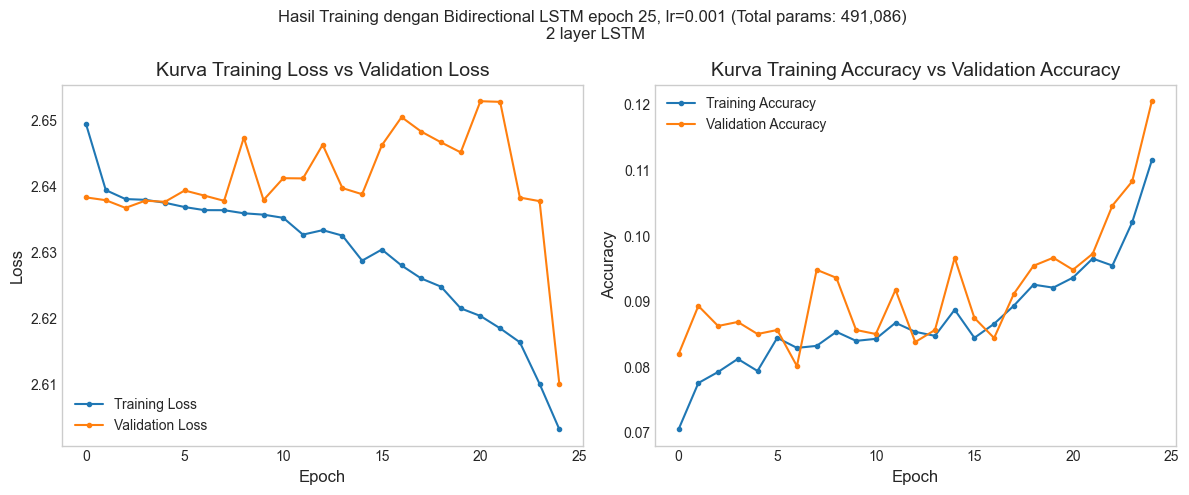

In [ ]:
# Visualisasi hasil training
history_training = pd.DataFrame(history.history)

plt.figure(figsize=(12, 5))
plt.suptitle(f'Hasil Training dengan Bidirectional LSTM epoch {epochs}, lr={lr} (Total params: 491,086) \n2 layer LSTM')

# Training Loss vs Validation Loss
plt.subplot(1, 2, 1)
plt.plot(history_training['loss'], label='Training Loss', marker='.')
plt.plot(history_training['val_loss'], label='Validation Loss', marker='.')
plt.title(f'Kurva Training Loss vs Validation Loss', fontdict={'fontsize': 14})
plt.xlabel('Epoch', fontdict={'fontsize': 12})
plt.ylabel('Loss', fontdict={'fontsize': 12})
plt.legend()
plt.grid()


# Training Accuracy vs Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(history_training['accuracy'], label='Training Accuracy', marker='.')
plt.plot(history_training['val_accuracy'], label='Validation Accuracy', marker='.')
plt.title(f'Kurva Training Accuracy vs Validation Accuracy', fontdict={'fontsize': 14})
plt.xlabel('Epoch', fontdict={'fontsize': 12})
plt.ylabel('Accuracy', fontdict={'fontsize': 12})
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

Prediksi pada data test untuk analisis
52/52 ━━━━━━━━━━━━━━━━━━━━ 14s 250ms/step

==== Classification Report ====

                     precision    recall  f1-score   support

             abroad       0.15      0.42      0.22       131
            address       0.11      0.48      0.18       126
          app_error       0.00      0.00      0.00       101
          atm_limit       0.04      0.01      0.01       119
            balance       0.12      0.14      0.13       120
      business_loan       0.07      0.03      0.04       116
        card_issues       0.00      0.00      0.00       120
       cash_deposit       0.04      0.01      0.01       122
       direct_debit       0.02      0.01      0.01       110
             freeze       0.00      0.00      0.00       112
 high_value_payment       0.14      0.51      0.22       110
      joint_account       0.50      0.01      0.02       119
latest_transactions       0.00      0.00      0.00       112
           pay_bill       0.11

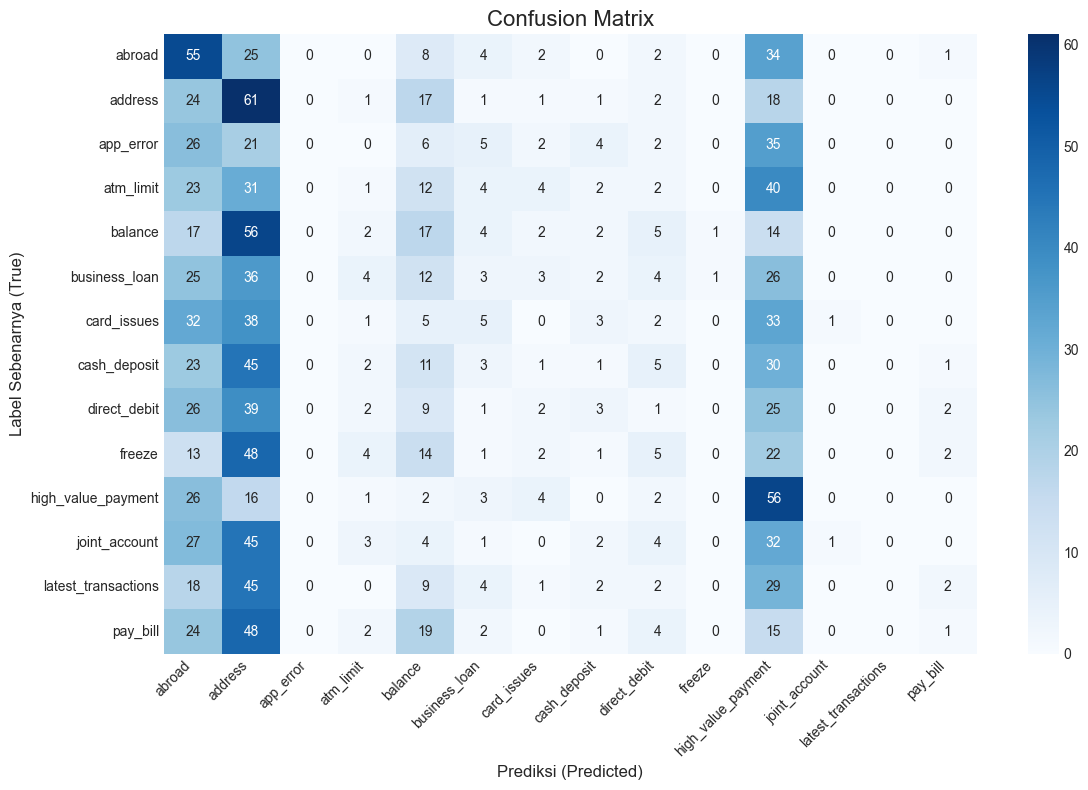

In [ ]:
print(f'Prediksi pada data test untuk analisis')
y_pred_probs = best_model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

target_names = label_encoder.classes_
target_names_str = [intent_names[i] for i in target_names]

print(f'\n==== Classification Report ====\n')
report = classification_report(y_true, y_pred, target_names=target_names_str, zero_division=0)
print(report)

print(f'\n==== Confusion Matrix ====\n')
cm = confusion_matrix(y_true, y_pred)

# Visualisasi heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names_str, yticklabels=target_names_str)
plt.title('Confusion Matrix', fontdict={'fontsize': 16})
plt.ylabel('Label Sebenarnya (True)', fontsize=12)
plt.xlabel('Prediksi (Predicted)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.tight_layout()
plt.show()